In [18]:
from data import Data
import numpy as np
import matplotlib.pyplot as plt

In [19]:
d = Data()
galaxies = d.getGalaxyData()
galaxy = np.array(galaxies['NGC5371_rotmod.dat'])

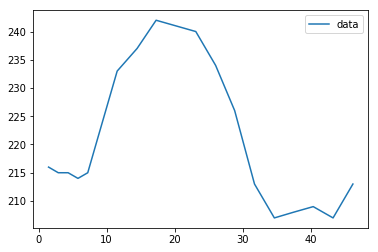

In [21]:
kpc = galaxy[:,0]
vobs = galaxy[:,1]
plt.plot(kpc, vobs)
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()